<a href="https://colab.research.google.com/github/Kfin2343/riboswitches/blob/main/Math463_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
num_seqs = 10000

#setup

In [2]:
import os, requests, io
import numpy as np
import pandas as pd
import glob
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, f1_score, accuracy_score, balanced_accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm
import statistics
from statistics import mean
from sklearn.preprocessing import StandardScaler
import random


In [3]:
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

In [4]:
#url = 'https://media.githubusercontent.com/media/midas-wyss/engineered-riboregulator-ML/master/data/downsampled_pruned_old_data.csv'
url = 'https://media.githubusercontent.com/media/lrsoenksen/CL_RNA_SynthBio/master/data/Toehold_Dataset_Final_2019-10-23.csv'
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ",") #pandas datatframe


In [5]:
mfes = df[['mfe_seq_AscendingStem', 'mfe_seq_DescendingStem',
       'mfe_seq_RBS_GFP', 'mfe_seq_RBS_Linker', 'mfe_seq_Stem',
       'mfe_seq_StemTop', 'mfe_seq_SwitchOFF', 'mfe_seq_SwitchOFF_GFP',
       'mfe_seq_SwitchOFF_NoTo', 'mfe_seq_SwitchON', 'mfe_seq_SwitchON_GFP',
       'mfe_seq_ToeholdOFF', 'mfe_seq_ToeholdON', 'mfe_seq_Trigger']]
       
mfes = np.asarray(mfes)
mfes1 = mfes[:num_seqs,:]

In [6]:
seqs = df[['seq_AscendingStem', 'seq_DescendingStem', 'seq_RBS_GFP',
       'seq_RBS_Linker', 'seq_Stem', 'seq_StemTop', 'seq_SwitchOFF',
       'seq_SwitchOFF_GFP', 'seq_SwitchOFF_NoTo', 'seq_SwitchON',
       'seq_SwitchON_GFP', 'seq_ToeholdOFF', 'seq_ToeholdON', 'seq_Trigger']]
       
seqs = np.asarray(seqs)
seqs = seqs[:num_seqs,:]

In [7]:
ixqx = range(0,14)

(10000, 1)
0
torch.Size([38, 10000, 4])
1
torch.Size([29, 10000, 4])
2
torch.Size([65, 10000, 4])
3
torch.Size([55, 10000, 4])
4
torch.Size([47, 10000, 4])
5
torch.Size([23, 10000, 4])
6
torch.Size([82, 10000, 4])
7
torch.Size([118, 10000, 4])
8
torch.Size([83, 10000, 4])
9
torch.Size([112, 10000, 4])
10
torch.Size([148, 10000, 4])
11
torch.Size([35, 10000, 4])
12
torch.Size([65, 10000, 4])
13
torch.Size([33, 10000, 4])
14
0.9239397760067702 0.04254456325654099


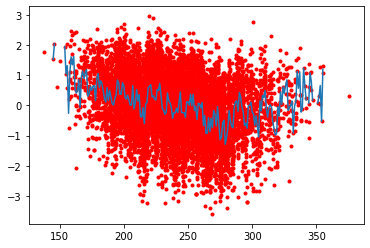

In [8]:
mfes = mfes1[:,ixqx]
mfes = np.sum(mfes, axis = 1)
mfes = mfes.reshape(-1,1)
scaler = StandardScaler()
y = scaler.fit_transform(mfes)
print(y.shape)
def sequence_one_hot(sequence_array):
  seq_list = []
  
  for a in sequence_array:
    split = []
    split = [char for char in a]
    seq_list.append(split)

  resnames = ['G', 'T', 'A', 'C']
    
  label_encoder = LabelEncoder()
  encode_names = label_encoder.fit_transform(resnames)
  code = dict(zip(resnames, encode_names))

  sequences = []
  for i in range(len(seq_list)):
    position_sequence = []
    for r in seq_list[i]:
      position = code[r]
      position_sequence.append(position)
    
    values = np.asarray(position_sequence).reshape(len(position_sequence), 1)
    onehot_encoder = OneHotEncoder(sparse=False) #build encoder
    enc = encode_names.reshape(len(encode_names),1) #reshape into two dimensions before fitting
    onehot_encoder.fit(enc)  #assign constant 'code' for one hot encoding from 'resnames' list above
    encoded_matrix = onehot_encoder.transform(values) #convert to [x,20] dimensions, one hot encoded
    sequences.append(encoded_matrix)

  lx = []
  lenx = []

  for a in sequences: 
      tensor = torch.tensor(a) #convert to tensor
      lx.append(tensor) #append to list
      lenx.append(a.shape[0]) #need length for pack_padded_sequence

  padded_sequence = pad_sequence(lx, padding_value=0)

  return padded_sequence, lenx

seq_list = []
for i in ixqx:
    print(i)
    padded_sequence, lengths = sequence_one_hot(sequence_array = seqs[:,i]) #processed data
    padded_sequence = padded_sequence.double() #dtype
    padded_sequence = padded_sequence.to(device) #cast to gpu
    print(padded_sequence.shape)
    seq_list.append(padded_sequence)

print(len(seq_list))

sequence_tensor = seq_list[0]

for i in range(1,len(seq_list)):
  a = seq_list[i]
  sequence_tensor = torch.cat((sequence_tensor,a), dim=0)
  x = sequence_tensor.double().to(device)


G_content = []
C_content = []
GC_content = []

for i in range(num_seqs):
  seq = x[:,i,:]
  C = np.asarray(seq[:,1].to('cpu'))
  C = np.sum(C)
  G = np.asarray(seq[:,2].to('cpu'))
  G = np.sum(G)
  C, G = int(C), int(G)
  GC = C+G
  G_content.append(G)
  C_content.append(C)
  GC_content.append(GC)

G = torch.tensor(G_content).double().to(device)
C = torch.tensor(C_content).double().to(device)
GC = torch.tensor(GC_content).double().to(device)

sorted_GC, indeces_GC = torch.sort(G)

mfeplot = torch.tensor(y)

holdout_size_ls = 1000
mses = []
for _ in range(30):
  holdout_indeces = random.sample(range(0, len(mfeplot)), holdout_size_ls)
  holdout_gc = sorted_GC[holdout_indeces]
  holdout_mfe=  mfeplot[holdout_indeces]
  all_indeces = np.asarray(range(len(mfeplot)))
  train_indeces = np.delete(all_indeces, holdout_indeces)
  train_gc = sorted_GC[train_indeces]
  train_mfe = mfeplot[train_indeces]
  A = np.vstack([train_gc.to('cpu'), 1/train_gc.to('cpu') , np.ones(len(train_gc))]).T  ###-1*np.log(train_GC.to('cpu'))
  m,l,b = np.linalg.lstsq(A, train_mfe , rcond=None)[0]
  from sklearn.metrics import mean_squared_error, mean_absolute_error
  y_pred = []
  y_true = []
  for i in range(len(holdout_gc)):
    ii = holdout_gc[i]
    ii = np.asarray(ii.to('cpu'))
    pred = m*ii + l/ii + b 
    true = holdout_mfe[i]
    y_pred.append(pred)
    y_true.append(true)

  y_pred = np.asarray(y_pred)
  y_true = np.asarray(y_true)

  mse = mean_squared_error(y_true, y_pred)
  mses.append(mse)
mses = np.asarray(mses)

print(mses.mean(), mses.std())

plt.plot(sorted_GC.to('cpu'), mfeplot, 'r.')

arr = sorted_GC.to('cpu')
avgs = []
for i in range(int(arr[0]), int(arr[-1])+1):
  a = np.where(arr == i)
  if len(a) == 0:
    pass
  else:
    b = mfeplot[a]
    c = b.mean()
    avgs.append(c)

xx =  range(int(arr[0]), int(arr[-1])+1)
avgs = np.asarray(avgs)
plt.plot(xx, avgs )

In [9]:
y = torch.tensor(mfeplot).double().to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [10]:
class dataset(data.Dataset):
  def __init__(self, x, t):
    self.x = x
    self.t = t
  def __len__(self):
    return len(self.x[0,:,0])
  def __getitem__(self, index):
    X = self.x[:, index, :]
    T = self.t[index, :]
    return X, T

In [11]:
def process_generated(gen):
  test = gen.reshape(padded_sequence.size(0),4).to('cpu')
  test = np.asarray(test.detach())

  pred_binary = np.zeros_like(test)
  pred_binary[np.arange(len(test)), test.argmax(1)] = 1

  a = np.sum(test, 1)

  #plt.plot(a)
  #plt.show()

  stop_point = []
  for i, j in enumerate(a):
    if j <=.1:
      stop_point.append(i)

  #print(stop_point[0:4])
  if not stop_point:
    pass
  elif stop_point[0] <= 40:
    pass
  else:
    pred_binary = pred_binary[:stop_point[0],:]

  s = []
  for i in pred_binary:
    if i[0] == 1:
      s.append('A')
    elif i[1] == 1:
      s.append('C')
    elif i[2] == 1:
      s.append('G')
    elif i[3] == 1:
      s.append('T')

  result = ''
  for element in s:
      result += str(element)

  generated = [result]

  seq, _ = sequence_one_hot(generated)
  #print(seq.size(0))
  zeros = torch.zeros((padded_sequence.size(0)-seq.size(0),1,4))
  generated_sequence = torch.cat((seq, zeros))


  g = generated_sequence.permute(1,0,2)
  g = g.to(device)
  
  return generated, g


#mfe regression

In [12]:
class NN(nn.Module):
  def __init__(self, drop_p = .3, batch_size= 1):
    super(NN, self).__init__()
    self.drop_p = drop_p
    self.batch_size = batch_size

    self.dense = nn.Sequential(
        nn.Linear(x.shape[0]*4, 528),
        nn.LeakyReLU(),
        nn.Dropout(p= drop_p),
        nn.Linear(528,528),
        nn.LeakyReLU(),
        nn.Dropout(p= drop_p),
        nn.Linear(528,128),
        nn.LeakyReLU(),
        nn.Dropout(p=drop_p),
        nn.Linear(128, 1))

  def forward(self, x):
    x = x.flatten(1,2)
    out = self.dense(x)
    return out

In [13]:
def train(device, optim, loader, model):
  model.train()
  losses = []
  length_list = []
  for i, (x,y) in enumerate(loader):
    #set gradients to zero
    model.zero_grad()
    #send inputs to GPU
    x, y = x.double().to(device), y.double().to(device)
    #forward pass through model
    y_pred = model(x)
    #calculate loss, backwards step, update gradients
    critereon = nn.MSELoss()
    y_pred = y_pred.flatten()
    y = y.flatten()
    loss = critereon(y_pred, y)
    loss.backward()
    optim.step()
    #cumulative loss
    losses.append(loss.item())

  return losses

def test_rnn(device, loader,model):
  #set to evaluation mode
  model.eval()
  #start with 0 loss and empty lists
  test_loss = 0
  all_y_pred = []
  all_y = []
  #use no gradient for evaluation
  with torch.no_grad():
   for i, (x,y) in enumerate(loader):
     #cast to GPU
    x,y = x.to(device), y.to(device)
    #forward pass through model
    y_pred = model(x)
    all_y_pred.extend(y_pred)
    all_y.extend(y)
    #calculate loss
    criterion = nn.MSELoss()
    test_loss += criterion(y_pred.double().flatten(), y.double().flatten())
    #test_loss /= len(test_loader.dataset)

  all_y_pred_tensor = torch.stack(all_y_pred, dim=0)
  all_y_tensor = torch.stack(all_y, dim=0)


  return test_loss, all_y_pred_tensor, all_y_tensor

In [14]:
batch_size = 300
epochs = 100

In [15]:
y = y.reshape(-1,1)
print(y.shape)

torch.Size([10000, 1])


In [16]:
trainlosses = []
testlosses = []
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(np.ones((y.shape[0])))
for i, (train_index,test_index) in enumerate(skf.split(np.ones(y.shape[0]), np.ones(y.shape[0]))):
  if i == 0:
    model = NN().to(device)
    model = model.double()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)

    train_loader = data.DataLoader(dataset(x[:,train_index,:], y[train_index,:]), batch_size=batch_size)
    test_loader = data.DataLoader(dataset(x[:,test_index,:], y[test_index,:]), batch_size=batch_size)

    for epoch in range(epochs):
      train_losses = train(device, optimizer, train_loader, model=model)
      test_loss, y_pred_test1, y_test1= test_rnn(device, test_loader, model=model)
      avg_train_loss = sum(train_losses)/len(train_losses)
      print('epoch:', epoch, 'loss:', avg_train_loss, "test:", test_loss)
      trainlosses.append(avg_train_loss)
      testlosses.append(test_loss)
      
      mse = mean_squared_error(y_test1.flatten().to('cpu'), y_pred_test1.flatten().to('cpu'))
    print(mse)

  else:
    pass



epoch: 0 loss: 0.5583285022593735 test: tensor(0.6533, device='cuda:0', dtype=torch.float64)
epoch: 1 loss: 0.222104178680861 test: tensor(0.6778, device='cuda:0', dtype=torch.float64)
epoch: 2 loss: 0.14364940830965256 test: tensor(0.3403, device='cuda:0', dtype=torch.float64)
epoch: 3 loss: 0.1033825277658205 test: tensor(0.3183, device='cuda:0', dtype=torch.float64)
epoch: 4 loss: 0.09026277432241446 test: tensor(0.3206, device='cuda:0', dtype=torch.float64)
epoch: 5 loss: 0.08536993054576245 test: tensor(0.4289, device='cuda:0', dtype=torch.float64)
epoch: 6 loss: 0.07410072586421829 test: tensor(0.3481, device='cuda:0', dtype=torch.float64)
epoch: 7 loss: 0.0735261921146293 test: tensor(0.2271, device='cuda:0', dtype=torch.float64)
epoch: 8 loss: 0.0700639541345445 test: tensor(0.2517, device='cuda:0', dtype=torch.float64)
epoch: 9 loss: 0.07400991034092087 test: tensor(0.2571, device='cuda:0', dtype=torch.float64)
epoch: 10 loss: 0.0860384348281778 test: tensor(0.3871, device='cu

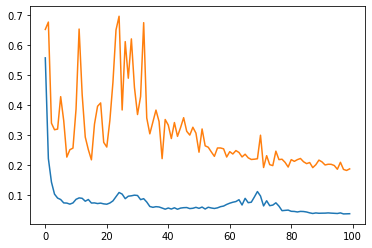

In [17]:
l = [trainlosses, testlosses]
for i in l:
  plt.plot(i)

In [18]:
yy = scaler.inverse_transform(y_pred_test1.to('cpu'))
yyy = scaler.inverse_transform(y_test1.to('cpu'))

dif = abs(yy-yyy)

In [19]:
d = []
e = []
for i in range(14):
  a = dif[i]
  b = yyy[i]
  c = np.sqrt(sum(a**2)/len(a))
  d.append(b.std()/c)
  e.append(a.mean())
print('raise', mean(d), '\nlower', mean(e))

raise 0.0 
lower 8.832243226573764


#mfe RNN

In [20]:
class RNN(nn.Module):
  def __init__(self, drop_p = .3, batch_size= 1):
    super(RNN, self).__init__()
    self.drop_p = drop_p
    self.batch_size = batch_size
    self.gru = nn.GRU(input_size=4, hidden_size=100, num_layers = 2, bidirectional = True, batch_first = True, dropout = .3)
    self.dense = nn.Sequential(
        nn.Linear(400, 1))

  def forward(self, x):
    _, h = self.gru(x)
    h = h.permute(1,0,2)
    h = torch.flatten(h, 1,2)
    out = self.dense(h)
    return out

In [21]:
def train(device, optim, loader, model):
  model.train()
  losses = []
  length_list = []
  for i, (x,y) in enumerate(loader):
    #set gradients to zero
    model.zero_grad()
    #send inputs to GPU
    x, y = x.double().to(device), y.double().to(device)
    #forward pass through model
    y_pred = model(x)
    #calculate loss, backwards step, update gradients
    critereon = nn.MSELoss()
    y_pred = y_pred.flatten()
    y = y.flatten()
    loss = critereon(y_pred, y)
    loss.backward()
    optim.step()
    #cumulative loss
    losses.append(loss.item())

  return losses

def test_rnn(device, loader,model):
  #set to evaluation mode
  model.eval()
  #start with 0 loss and empty lists
  test_loss = 0
  all_y_pred = []
  all_y = []
  #use no gradient for evaluation
  with torch.no_grad():
   for i, (x,y) in enumerate(loader):
     #cast to GPU
    x,y = x.to(device), y.to(device)
    #forward pass through model
    y_pred = model(x)
    all_y_pred.extend(y_pred)
    all_y.extend(y)
    #calculate loss
    criterion = nn.MSELoss()
    test_loss += criterion(y_pred.double().flatten(), y.double().flatten())
    #test_loss /= len(test_loader.dataset)

  all_y_pred_tensor = torch.stack(all_y_pred, dim=0)
  all_y_tensor = torch.stack(all_y, dim=0)


  return test_loss, all_y_pred_tensor, all_y_tensor

In [22]:
batch_size = 300
epochs = 100

In [23]:
y = y.reshape(-1,1)
print(y.shape)

torch.Size([10000, 1])


In [24]:
trainlosses = []
testlosses = []
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(np.ones((y.shape[0])))
for i, (train_index,test_index) in enumerate(skf.split(np.ones(y.shape[0]), np.ones(y.shape[0]))):
  if i == 0:
    model = RNN().to(device)
    model = model.double()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)

    train_loader = data.DataLoader(dataset(x[:,train_index,:], y[train_index,:]), batch_size=batch_size)
    test_loader = data.DataLoader(dataset(x[:,test_index,:], y[test_index,:]), batch_size=batch_size)

    for epoch in range(epochs):
      train_losses = train(device, optimizer, train_loader, model=model)
      test_loss, y_pred_test1, y_test1= test_rnn(device, test_loader, model=model)
      avg_train_loss = sum(train_losses)/len(train_losses)
      print('epoch:', epoch, 'loss:', avg_train_loss, "test:", test_loss)
      trainlosses.append(avg_train_loss)
      testlosses.append(test_loss)
      
      mse = mean_squared_error(y_test1.flatten().to('cpu'), y_pred_test1.flatten().to('cpu'))
    print('\n final MSE:', mse)

  else:
    pass



epoch: 0 loss: 0.8738323574844306 test: tensor(3.8758, device='cuda:0', dtype=torch.float64)
epoch: 1 loss: 0.49187180934593044 test: tensor(0.5978, device='cuda:0', dtype=torch.float64)
epoch: 2 loss: 0.1295525827409166 test: tensor(0.4027, device='cuda:0', dtype=torch.float64)
epoch: 3 loss: 0.09503944370743414 test: tensor(0.3634, device='cuda:0', dtype=torch.float64)
epoch: 4 loss: 0.09369979052657565 test: tensor(0.3479, device='cuda:0', dtype=torch.float64)
epoch: 5 loss: 0.08652018329236696 test: tensor(0.3200, device='cuda:0', dtype=torch.float64)
epoch: 6 loss: 0.08287589883834415 test: tensor(0.3253, device='cuda:0', dtype=torch.float64)
epoch: 7 loss: 0.08078051010664625 test: tensor(0.3078, device='cuda:0', dtype=torch.float64)
epoch: 8 loss: 0.07955956846289772 test: tensor(0.3063, device='cuda:0', dtype=torch.float64)
epoch: 9 loss: 0.07821829236640035 test: tensor(0.3269, device='cuda:0', dtype=torch.float64)
epoch: 10 loss: 0.08403530260057365 test: tensor(0.2757, devic

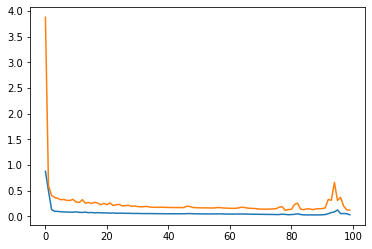

In [25]:
l = [trainlosses, testlosses]
for i in l:
  plt.plot(i)

In [26]:
yy = scaler.inverse_transform(y_pred_test1.to('cpu'))
yyy = scaler.inverse_transform(y_test1.to('cpu'))

dif = abs(yy-yyy)

In [27]:
d = []
e = []
for i in range(14):
  a = dif[i]
  b = yyy[i]
  c = np.sqrt(sum(a**2)/len(a))
  d.append(b.std()/c)
  e.append(a.mean())
print('raise', mean(d), '\nlower', mean(e))

raise 0.0 
lower 8.124096977336933


In [28]:
from sklearn.metrics import r2_score

In [29]:
r2 = r2_score(y_test1.flatten().to('cpu'), y_pred_test1.flatten().to('cpu'))
print(r2)

0.9712641289015506
